In [1]:
import tensorflow as tf

import numpy as np
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
#import cifar100label

2025-02-24 10:08:36.254632: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
NUM_EPOCH = 50

# training SNR
eb_n0 = 20
rate = 1 # code rate 

# ##### KSG MI estimator #######################
# settings = {'kraskov_k': 3}
# gpu_est = est.OpenCLKraskovMI(settings = settings)
# usage: MI = estimator.estimate(var1, var2)

##### setting for communication channel ######

def getnoisevariance(SNR,rate,P=1):
    # the SNR in args[0] is actually EbN0
    snrdB = SNR + 10*np.log10(rate)
    snr = 10.0**(snrdB/10.0)
    #P_avg = 1
    N0 = P/snr
    return (N0/2)

noise_var = getnoisevariance(eb_n0,rate,P=1)
sd = np.sqrt(noise_var)

##############################################


### DATA Preprocessing

In [13]:
(x_train_val, y_train_val), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# x_train_val = x_train_val.reshape(x_train.shape[0], -1)
# x_test = x_test.reshape(x_test.shape[0], -1)

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

Y_train_val = tf.keras.utils.to_categorical(y_train_val, 10)
Y_test = tf.keras.utils.to_categorical(y_test, 10)

#del y_train_val,y_test

In [14]:

label_permutation = np.arange(10)
#label_permutation = np.random.permutation(10)
LABEL_FIRST_HALF = label_permutation[:5]
label2_list = np.zeros((6,5))
for i in range(6):
    label2_list[i][:] = label_permutation[i:i+5]
    
print(label2_list)

train_filter = np.where(np.in1d(y_train_val, LABEL_FIRST_HALF))
test_filter =  np.where(np.in1d(y_test, LABEL_FIRST_HALF))

[[0. 1. 2. 3. 4.]
 [1. 2. 3. 4. 5.]
 [2. 3. 4. 5. 6.]
 [3. 4. 5. 6. 7.]
 [4. 5. 6. 7. 8.]
 [5. 6. 7. 8. 9.]]


In [15]:
x_train_1 = x_train_val[train_filter]
Y_train_1 = Y_train_val[train_filter]
x_test_1 = x_test[test_filter]
Y_test_1 = Y_test[test_filter]

In [16]:
train_val_ratio = 0.8
train_num = int(x_train_1.shape[0]*train_val_ratio)
print(train_num)

# x_train, x_val = x_train_val[:train_num], x_train_val[train_num:]
# Y_train, Y_val = Y_train_val[:train_num], Y_train_val[train_num:]
# del x_train_val, y_train_val

20000


### Model Structure

In [17]:
### normalized Input before 
class GaussianNoiseLayer(layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianNoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev
    
    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
        else:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
    
    def get_config(self):
        config = super(GaussianNoiseLayer, self).get_config()
        config.update({'noise_var': self.stddev})
        return config

In [18]:
class CustomMetricCallback(tf.keras.callbacks.Callback):
    def __init__(self, display_frequency=10):
        super(CustomMetricCallback, self).__init__()
        self.display_frequency = display_frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.display_frequency == 0:
            metrics_str = " - ".join([f"{metric_name}: {value:.4f}" for metric_name, value in logs.items()])
            print(f"Epoch {epoch}/{self.params['epochs']} - {metrics_str}")

            
callback = CustomMetricCallback(display_frequency=50)

In [19]:
key_list = ['loss', 'CE_loss', 'mse_loss', 'CE_accuracy', 'mse']
results_list = {key: [] for key in key_list}
print(results_list)
# [results_list[key_list[i]].append(results[i]) for i in range(len(key_list))]
# print(results_list)

{'loss': [], 'CE_loss': [], 'mse_loss': [], 'CE_accuracy': [], 'mse': []}


In [12]:

def do_report(epoch):
#     if epoch < 20:       # Log for all first 20 epochs
#         return True
    if epoch < 100:    # Then for every 5th epoch
        return (epoch % 5 == 0)
    elif epoch < 200:    # Then every 10th
        return (epoch % 10 == 0)
    else:                # Then every 100th
        return (epoch % 100 == 0)
    
    
def train_first_stage(lambda_val,results_list):

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

        ############ Model Structure ###############################

    input_layer  = layers.Input(shape=(32, 32, 3))
    unlabeled_input = layers.Input(shape=(32, 32, 3))
    encoder_1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(input_layer)
    encoder_1 = layers.AveragePooling2D(pool_size=(2, 2))(encoder_1)
    encoder_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_1)
    maxpool_2 = layers.AveragePooling2D((2, 2))(encoder_2)
    encoder_3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(maxpool_2)
    
    #x = layers.Dropout(0.25)(maxpool_2)
    normalized_x = tf.keras.layers.Lambda(lambda x: K.tanh(x))(maxpool_2)
    noise_layer = GaussianNoiseLayer(stddev = sd)(normalized_x)

    CE_cnn_1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(noise_layer)
    #CE_cnn_1 = layers.AveragePooling2D(pool_size=(2, 2))(CE_cnn_1)
    CE_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(CE_cnn_1)
    
    flatten_1 = layers.Flatten()(CE_2)
    flatten_1 = layers.BatchNormalization()(flatten_1)
    CE_dense_2 = layers.Dense(256, activation='relu')(flatten_1)
    CE_output = tf.keras.layers.Dense(10,activation = 'softmax',name='CE')(CE_dense_2)
    #CE_output = tf.keras.layers.Dense(10,activation = 'softmax',name='CE')(CE_decoder_2)

    #dense_2 = layers.Dense(64, activation='relu')(flatten_1)
    mse_1 = layers.Conv2DTranspose(128, kernel_size=3, activation='relu', padding='same')(noise_layer)
    upsample1 = layers.UpSampling2D((2,2))(mse_1)
    mse_2 = layers.Conv2DTranspose(128, kernel_size=3, activation='relu', padding='same')(upsample1)
    upsample2 = layers.UpSampling2D((2,2))(mse_2)
    mse_output = layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same',name='mse')(upsample2)


    model = tf.keras.Model(inputs = input_layer, outputs = [CE_output,mse_output])
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=10000,
    decay_rate=0.9)
    opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    model.compile(optimizer=opt,
                  loss = {'CE' : 'categorical_crossentropy', 
                          'mse' : 'mse'},
                  metrics = {'CE' : 'accuracy', 
                             'mse': tf.keras.metrics.RootMeanSquaredError()},
                  loss_weights=[1, lambda_val])


    SNR = eb_n0
    #     print("current snr: ",SNR)
    # #     print("====================")
    #     reporter = getMIOutput(trn=x_1train, 
    #                                tst=x_1test, 
    #                                snr=SNR,
    #                               do_save_func=do_report)

    history = model.fit(x=x_train_1, y=(Y_train_1,x_train_1),
                        batch_size=128,
                        epochs=100,
                        verbose=0,
                        validation_data=(x_test_1, (Y_test_1,x_test_1)))
                       #callbacks = [callback])
                        #callbacks=[reporter,])
            

    ################### secpmd stage #################
    #print("stage 2!")
   
    train_filter = np.where(np.in1d(y_train_val, LABEL_SECOND_HALF))
    test_filter =  np.where(np.in1d(y_test, LABEL_SECOND_HALF))

    x_trainval_2 = x_train_val[train_filter]
    x_test_2 = x_test[test_filter]
    Y_trainval_2 = Y_train_val[train_filter]
    Y_test_2 = Y_test[test_filter]

    x_train_2, x_val_2 = x_trainval_2[:train_num], x_trainval_2[train_num:]
    Y_train_2, Y_val_2 = Y_trainval_2[:train_num], Y_trainval_2[train_num:]

    
    CE_cnn_2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(noise_layer)
    CE_cnn_2 = layers.AveragePooling2D(pool_size=(2, 2))(CE_cnn_2)
    CE_cnn_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(CE_cnn_2)
    
    flatten_2 = layers.Flatten()(CE_2)
    flatten_2 = layers.BatchNormalization()(flatten_2)
    CE_dense_3 = layers.Dense(256, activation='relu')(flatten_2)
    CE_output1 = tf.keras.layers.Dense(10,activation = 'softmax',name='CE')(CE_dense_3)
    
    
    reconstructed_model = tf.keras.models.Model(inputs = input_layer, outputs = [CE_output1,mse_output])

    reconstructed_model.layers[1].trainable = False
    reconstructed_model.layers[2].trainable = False

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-2,
    decay_steps=10000,
    decay_rate=0.95)
    opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)


    reconstructed_model.compile(optimizer="Adam", 
                loss = {'CE' : 'categorical_crossentropy', 
                          'mse' : 'mse'
                         },              loss_weights=[1, 0],
                  metrics = {'CE' : 'accuracy', 
                             'mse': tf.keras.metrics.RootMeanSquaredError()
                           }
                 )

    #     reporter_2 = getMIOutput(trn=x_retrain, 
    #                                tst=Y_retrain, 
    #                                snr=SNR,
        #                               do_save_func=do_report)
        
    history1 = reconstructed_model.fit(x=x_train_2, y=(Y_train_2,x_train_2),
                        batch_size=128,
                        epochs=100,
                        verbose=0,
                        validation_data=(x_val_2,(Y_val_2,x_val_2)))
    
    results = reconstructed_model.evaluate(x_test_2,(Y_test_2,x_test_2))
    
    [results_list[key_list[i]].append(results[i]) for i in range(len(key_list))]
        
    print(history1.history['val_CE_accuracy'][-1])
        
    return results_list

    

In [13]:
key_list = ['loss', 'CE_loss', 'mse_loss', 'CE_accuracy', 'mse']
results_list = {key: [] for key in key_list}
lambda_list = [0,1,2,5,10]

for i in range(6):
    print("current overlap is: ", (i) )
    acc_list = []
    LABEL_SECOND_HALF = label2_list[5-i]
    for lambda_val in lambda_list:
        print("lambda: ", lambda_val)
        results_list = train_first_stage(lambda_val,results_list)


current overlap is:  0
lambda:  0


2024-01-10 03:27:18.092544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77235 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-01-10 03:27:24.188152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2024-01-10 03:27:24.527429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-10 03:27:24.688117: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f53ecfb5a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-10 03:27:24.688160: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-01-10 03:27:24.756481: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled clus

157/157 [==============================] - 1s 4ms/step - loss: 1.3018 - CE_loss: 1.3018 - mse_loss: 0.0731 - CE_accuracy: 0.8134 - mse_root_mean_squared_error: 0.2703
0.8148000240325928
lambda:  1
157/157 [==============================] - 1s 3ms/step - loss: 1.3597 - CE_loss: 1.3597 - mse_loss: 0.1098 - CE_accuracy: 0.8074 - mse_root_mean_squared_error: 0.3313
0.8154000043869019
lambda:  2
157/157 [==============================] - 1s 3ms/step - loss: 2.0338 - CE_loss: 2.0338 - mse_loss: 0.1498 - CE_accuracy: 0.7370 - mse_root_mean_squared_error: 0.3871
0.7379999756813049
lambda:  5
157/157 [==============================] - 0s 3ms/step - loss: 1.3373 - CE_loss: 1.3373 - mse_loss: 0.0631 - CE_accuracy: 0.7968 - mse_root_mean_squared_error: 0.2513
0.8046000003814697
lambda:  10
157/157 [==============================] - 1s 3ms/step - loss: 1.6588 - CE_loss: 1.6588 - mse_loss: 0.1427 - CE_accuracy: 0.7716 - mse_root_mean_squared_error: 0.3777
0.772599995136261
current overlap is:  1
lam

In [15]:
import pickle 

with open('cifar10_acc_100ep.pkl', 'wb') as f:
    pickle.dump(results_list, f)

In [10]:
import pickle 
with open('cifar10_acc_100ep.pkl', 'rb') as f:
    x = pickle.load(f)

In [6]:
import numpy as np
np.array(x['CE_accuracy']).reshape(5,-1)

array([[0.81339997, 0.80739999, 0.73699999, 0.79680002, 0.77160001,
        0.77100003],
       [0.75220001, 0.75440001, 0.74839997, 0.73519999, 0.65359998,
        0.64660001],
       [0.64499998, 0.66659999, 0.61919999, 0.60299999, 0.55659997,
        0.597     ],
       [0.56739998, 0.56940001, 0.46000001, 0.6638    , 0.64160001,
        0.66320002],
       [0.65079999, 0.6602    , 0.6742    , 0.73720002, 0.72180003,
        0.71740001]])

In [18]:
np.array(results_list['CE_accuracy']).reshape(5,-1)

array([[0.81339997, 0.80739999, 0.73699999, 0.79680002, 0.77160001,
        0.77100003],
       [0.75220001, 0.75440001, 0.74839997, 0.73519999, 0.65359998,
        0.64660001],
       [0.64499998, 0.66659999, 0.61919999, 0.60299999, 0.55659997,
        0.597     ],
       [0.56739998, 0.56940001, 0.46000001, 0.6638    , 0.64160001,
        0.66320002],
       [0.65079999, 0.6602    , 0.6742    , 0.73720002, 0.72180003,
        0.71740001]])

In [ ]:
np.array([[0.81339997, 0.80739999, 0.73699999, 0.79680002, 0.77160001,
        0.77100003],
       [0.75220001, 0.75440001, 0.74839997, 0.73519999, 0.65359998,
        0.64660001],
       [0.64499998, 0.66659999, 0.61919999, 0.60299999, 0.55659997,
        0.597     ],
       [0.56739998, 0.56940001, 0.46000001, 0.6638    , 0.64160001,
        0.66320002],
       [0.65079999, 0.6602    , 0.6742    , 0.73720002, 0.72180003,
        0.71740001]])

In [21]:
1

1

In [69]:
lambda_val = 5
tf.keras.backend.clear_session()
tf.random.set_seed(42)

    ############ Model Structure ###############################

input_layer  = layers.Input(shape=(32, 32, 3))
unlabeled_input = layers.Input(shape=(32, 32, 3))
encoder_1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(input_layer)
encoder_1 = layers.AveragePooling2D(pool_size=(2, 2))(encoder_1)
encoder_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_1)
maxpool_2 = layers.AveragePooling2D((2, 2))(encoder_2)
encoder_3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(maxpool_2)

#x = layers.Dropout(0.25)(maxpool_2)
normalized_x = tf.keras.layers.Lambda(lambda x: K.tanh(x))(maxpool_2)
noise_layer = GaussianNoiseLayer(stddev = sd)(normalized_x)

CE_cnn_1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(noise_layer)
#CE_cnn_1 = layers.AveragePooling2D(pool_size=(2, 2))(CE_cnn_1)
CE_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(CE_cnn_1)

flatten_1 = layers.Flatten()(CE_2)
flatten_1 = layers.BatchNormalization()(flatten_1)
CE_dense_2 = layers.Dense(256, activation='relu')(flatten_1)
CE_output = tf.keras.layers.Dense(10,activation = 'softmax',name='CE')(CE_dense_2)
#CE_output = tf.keras.layers.Dense(10,activation = 'softmax',name='CE')(CE_decoder_2)

#dense_2 = layers.Dense(64, activation='relu')(flatten_1)
mse_1 = layers.Conv2DTranspose(128, kernel_size=3, activation='relu', padding='same')(noise_layer)
upsample1 = layers.UpSampling2D((2,2))(mse_1)
mse_2 = layers.Conv2DTranspose(128, kernel_size=3, activation='relu', padding='same')(upsample1)
upsample2 = layers.UpSampling2D((2,2))(mse_2)
mse_output = layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same',name='mse')(upsample2)


model = tf.keras.Model(inputs = input_layer, outputs = [CE_output,mse_output])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=5e-3,
decay_steps=10000,
decay_rate=0.9)
opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(optimizer=opt,
              loss = {'CE' : 'categorical_crossentropy', 
                      'mse' : 'mse'},
              metrics = {'CE' : 'accuracy', 
                         'mse': tf.keras.metrics.RootMeanSquaredError()},
              loss_weights=[1, lambda_val])


SNR = eb_n0
#     print("current snr: ",SNR)
# #     print("====================")
#     reporter = getMIOutput(trn=x_1train, 
#                                tst=x_1test, 
#                                snr=SNR,
#                               do_save_func=do_report)

history = model.fit(x=x_train_1, y=(Y_train_1,x_train_1),
                    batch_size=128,
                    epochs=100,
                    verbose=0,
                    validation_data=(x_test_1, (Y_test_1,x_test_1)))
                   #callbacks = [callback])
                    #callbacks=[reporter,])



782/782 [==============================] - 1s 802us/step


2024-12-10 11:48:44.304144: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3276800000 exceeds 10% of free system memory.


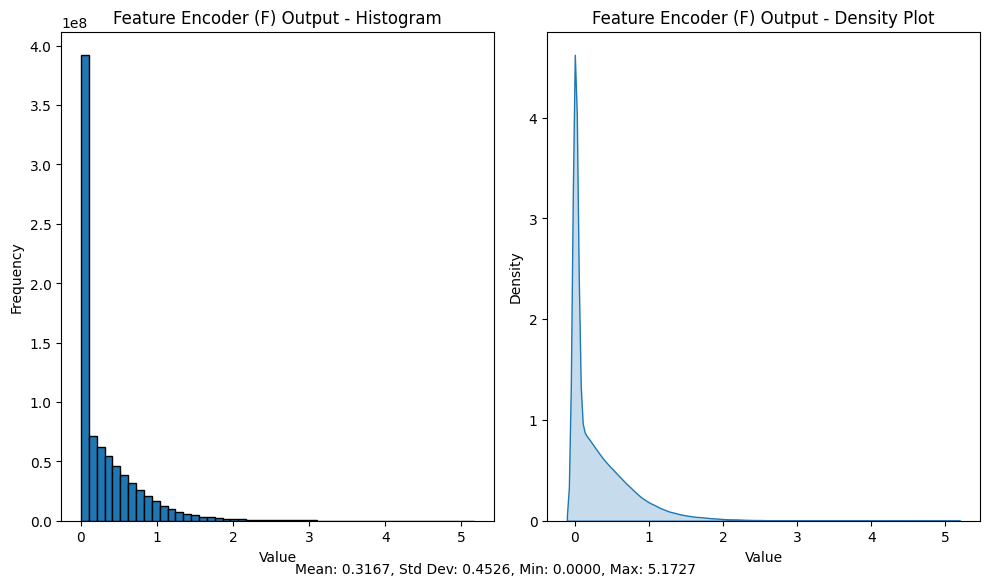

lambda:  5
Distribution Statistics:
Mean: 0.31670936942100525
Median: 0.12741625308990479
Standard Deviation: 0.4526231586933136
Min: 0.0
Max: 5.172668933868408


In [70]:
import seaborn as sns
def get_encoder_2_output(model, input_data):
    # Create an intermediate model that outputs the encoder_2 layer
    intermediate_model = tf.keras.Model(
        inputs=model.input, 
        outputs=model.get_layer('conv2d_1').output
    )
    
    # Get the output
    encoder_2_output = intermediate_model.predict(input_data)
    return encoder_2_output


# Plotting function
def plot_distribution(data, title):
    plt.figure(figsize=(10, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(data.flatten(), bins=50, edgecolor='black')
    plt.title(f'{title} - Histogram')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Kernel Density Estimation (KDE) plot
    plt.subplot(1, 2, 2)
    sampled_data = np.random.choice(data.flatten(), size=300000, replace=False)
    sns.kdeplot(sampled_data, fill=True)
    #sns.kdeplot(data.flatten(), fill=True)
    plt.title(f'{title} - Density Plot')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Add overall statistics as text
    plt.figtext(0.5, 0.01, 
                f'Mean: {np.mean(data):.4f}, '
                f'Std Dev: {np.std(data):.4f}, '
                f'Min: {np.min(data):.4f}, '
                f'Max: {np.max(data):.4f}', 
                ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
encoder_2_output = get_encoder_2_output(model, x_train_1)

plot_distribution(encoder_2_output, 'Feature Encoder (F) Output')
print("lambda: ",lambda_val)
# Optional: Check distribution properties
print("Distribution Statistics:")
print(f"Mean: {np.mean(encoder_2_output)}")
print(f"Median: {np.median(encoder_2_output)}")
print(f"Standard Deviation: {np.std(encoder_2_output)}")
print(f"Min: {np.min(encoder_2_output)}")
print(f"Max: {np.max(encoder_2_output)}")

In [71]:
print("number of position in 128 filters that are all zeros: ",np.sum(sum((encoder_2_output == 0))==0)/(16*16*128))
print("numbers of total zeros: ",np.sum((encoder_2_output == 0))/(x_train_1.shape[0]*16*16*128))

number of position in 128 filters that are all zeros:  0.0115966796875
numbers of total zeros:  0.3762195642089844


In [57]:
print("numbers of total zeros: ",np.sum((encoder_2_output == 0))/(x_train_1.shape[0]*16*16*128))

numbers of total zeros:  0.4053719104003906


In [ ]:
128/()

In [11]:
# Optional: Check distribution properties
print("Distribution Statistics:")
print(f"Mean: {np.mean(data)}")
print(f"Median: {np.median(data)}")
print(f"Standard Deviation: {np.std(data)}")
print(f"Min: {np.min(data)}")
print(f"Max: {np.max(data)}")

Distribution Statistics:
Mean: 0.32451552152633667
Median: 0.13003845512866974
Standard Deviation: 0.472200870513916
Min: 0.0
Max: 5.595498085021973


In [ ]:
data.